In [1]:
import xarray as xr

import glob
import os
import datetime as dt

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd

In [ ]:
# the zarr file is only stored on the linux box so this cell cannot be run on my local computer
zarr_path = '/storage/GOES/orthorectified/Fog2022_withtime.zarr'
ds = xr.open_dataset(
    zarr_path,
    chunks={'time': 40785, 'latitude': 50, 'longitude': 50},
    engine='zarr'
)
# When we pass in a chunks argument, the dataset opened will be filled with Dask arrays

In [ ]:
height = ds['Height']

In [ ]:
fhl = (48.55, -123.01)
fhl_timeseries = ds['Height'].sel(latitude = fhl[0], longitude = fhl[1], method='nearest')
# Convert the timeseries into a pandas dataframe and save in a .csv file to access easily even without access to the zarr file
# fhl_timeseries.to_dataframe().to_csv('fhl_cloudheight_df.csv')  # took 4 mins

In [8]:
mtdallas = (48.53, -123.13)
mtdallas_timeseries = ds['Height'].sel(latitude = mtdallas[0], longitude = mtdallas[1], method='nearest')
# mtdallas_timeseries.to_dataframe().to_csv('mtdallas_cloudheight_df.csv') # took only 10 seconds?!

## Whidbey island

In [4]:
whidbey = (48.350,-122.650)
whidbey_timeseries = ds['Height'].sel(latitude = whidbey[0], longitude = whidbey[1], method='nearest')

In [13]:
clear = whidbey_timeseries.isnull().sum().values
clear_freq = clear/whidbey_timeseries['time'].size
clear_freq

0.1061174451391443

In [12]:
under_2000 = (whidbey_timeseries < 2000).sum().values
under_2000_freq = under_2000/whidbey_timeseries['time'].size
under_2000_freq

0.3407134976094152

In [16]:
under_600 = (whidbey_timeseries < 600).sum().values
under_600_freq = under_600/whidbey_timeseries['time'].size
under_600_freq

0.034547014833885004

## False Bay

### From zarr dataset

In [15]:
# Get the timeseries of cloud height values at False Bay from the dataset of all the rasters
falsebay = (48.48, -123.06)
falsebay_timeseries = height.sel(latitude = falsebay[0], longitude = falsebay[1], method='nearest')
falsebay_timeseries = falsebay_timeseries.sel(time = slice('May 01, 2022', 'July 18, 2022')) # sel only work for xarray DataArray

### From csv file

In [31]:
# If don't have access to the zarr file to read the dataset, get the timeseries data from the csv file that is saved previously
falsebay_df = pd.read_csv('/Users/autumn_yngoc/Downloads/Marine Fog/summerfog/cloud_height_timeseries/falsebay_cloudheight_df.csv', parse_dates=True)

In [32]:
falsebay_df['time'] = pd.to_datetime(falsebay_df['time'])
falsebay_df.set_index('time', inplace=True)

In [33]:
falsebay_timeseries = falsebay_df['Height'].to_xarray()
falsebay_timeseries

<xarray.DataArray 'Height' (time: 40785)>
array([ 770.63934,  698.9165 ,        nan, ...,        nan, 2023.5006 ,
       2014.3445 ])
Coordinates:
  * time     (time) datetime64[ns] 2022-04-30T17:01:17 ... 2022-09-30T16:51:17

### Frequency calculation

In [36]:
falsebay_timeseries_mayjul = falsebay_timeseries.sel(time=slice('May 01, 2022', 'July 18, 2022'))
falsebay_timeseries_mayjul

<xarray.DataArray 'Height' (time: 21872)>
array([808.7898 , 794.14   , 769.72375, ...,       nan,       nan,
             nan])
Coordinates:
  * time     (time) datetime64[ns] 2022-05-01T05:01:17 ... 2022-07-18T23:56:17

In [37]:
# Select only the hours between 5am and 8pm, which are the hours that the field cameras take pictures,
# so that we can compare the frequency of fog/low clouds between satellite-derived cloud height and camera-derived fog classification
falsebay_timeseries_mayjul = falsebay_timeseries_mayjul.isel(time=falsebay_timeseries_mayjul.time.dt.hour.isin(range(6,20)))
under_2000 = (falsebay_timeseries_mayjul < 2000).sum().values
print(under_2000/falsebay_timeseries_mayjul['time'].size)
under_600 = (falsebay_timeseries_mayjul < 600).sum().values
print(under_600/falsebay_timeseries_mayjul['time'].size)

0.2386122077133313
0.04653811114485272


In [39]:
falsebay_timeseries_jun = falsebay_timeseries.sel(time=slice('June 01, 2022', 'June 30, 2022'))
print(f"NaN (clear sky) frequency: {np.isnan(falsebay_timeseries_jun).sum().values/falsebay_timeseries_jun['time'].size}")
falsebay_timeseries_jun

NaN (clear sky) frequency: 0.09163577386468953


<xarray.DataArray 'Height' (time: 8632)>
array([9314.512, 9200.365, 9238.517, ...,      nan,      nan,      nan])
Coordinates:
  * time     (time) datetime64[ns] 2022-06-01T00:01:17 ... 2022-06-30T23:56:17

In [44]:
falsebay_timeseries_jul = falsebay_timeseries.sel(time=slice('July 01, 2022', 'July 31, 2022'))
print(f"NaN (clear sky) frequency: {np.isnan(falsebay_timeseries_jul).sum().values/falsebay_timeseries_jul['time'].size}")
falsebay_timeseries_jul

NaN (clear sky) frequency: 0.154408457040036


<xarray.DataArray 'Height' (time: 8892)>
array([      nan,       nan,       nan, ..., 9170.456 , 5983.2134,
       6106.2104])
Coordinates:
  * time     (time) datetime64[ns] 2022-07-01T00:01:17 ... 2022-07-31T23:56:17

In [43]:
falsebay_timeseries_aug = falsebay_timeseries.sel(time=slice('August 01, 2022', 'August 31, 2022'))
print(f"NaN (clear sky) frequency: {np.isnan(falsebay_timeseries_aug).sum().values/falsebay_timeseries_aug['time'].size}")
falsebay_timeseries_aug

NaN (clear sky) frequency: 0.21022483173421166


<xarray.DataArray 'Height' (time: 6983)>
array([6555.7754, 6195.33  , 6659.2397, ...,       nan, 1719.2125,
             nan])
Coordinates:
  * time     (time) datetime64[ns] 2022-08-01T00:01:17 ... 2022-08-31T22:56:17

## Mt Dallas

In [6]:
mtdallas = (48.53, -123.13)
mtdallas_timeseries = ds['Height'].sel(latitude = mtdallas[0], longitude = mtdallas[1], method='nearest')
mtdallas_timeseries = mtdallas_timeseries.sel(time = slice('July 19, 2022', 'September 30, 2022'))

In [45]:
# If don't have access to the zarr file to read the dataset, get the timeseries data from the csv file that is saved previously
mtdallas_df = pd.read_csv('/Users/autumn_yngoc/Downloads/Marine Fog/summerfog/cloud_height_timeseries/mtdallas_cloudheight_df.csv')

In [46]:
mtdallas_df['time'] = pd.to_datetime(mtdallas_df['time'])
mtdallas_df.set_index('time', inplace=True)

In [47]:
mtdallas_timeseries = mtdallas_df['July 19, 2022': 'September 30, 2022']['Height']
mtdallas_timeseries

time
2022-07-19 00:01:17    2278.6510
2022-07-19 00:06:17    2243.5525
2022-07-19 00:11:17    2247.5200
2022-07-19 00:16:17    2264.6116
2022-07-19 00:21:17    2202.9604
                         ...    
2022-09-30 16:31:17    2056.1575
2022-09-30 16:36:17    1989.6229
2022-09-30 16:41:17    1967.6483
2022-09-30 16:46:17    1873.6455
2022-09-30 16:51:17    1857.4697
Name: Height, Length: 18841, dtype: float64

In [48]:
mtdallas_timeseries = mtdallas_timeseries.to_xarray()
mtdallas_timeseries

<xarray.DataArray 'Height' (time: 18841)>
array([2278.651 , 2243.5525, 2247.52  , ..., 1967.6483, 1873.6455,
       1857.4697])
Coordinates:
  * time     (time) datetime64[ns] 2022-07-19T00:01:17 ... 2022-09-30T16:51:17

In [49]:
under_2000 = (mtdallas_timeseries < 2000).sum().values
under_2000_freq = under_2000/mtdallas_timeseries['time'].size
under_2000_freq

0.5320842842736585

In [11]:
under_600 = (mtdallas_timeseries < 600).sum().values
under_600_freq = under_600/mtdallas_timeseries['time'].size
under_600_freq

0.27312775330396477

In [54]:
mtdallas_timeseries = mtdallas_timeseries.isel(time=mtdallas_timeseries.time.dt.hour.isin(range(6,20)))
under_2000 = (mtdallas_timeseries < 2000).sum().values
print(under_2000/mtdallas_timeseries['time'].size)
under_600 = (mtdallas_timeseries < 600).sum().values
print(under_600/mtdallas_timeseries['time'].size)

0.5539432693884243
0.2690605017215937


## Friday Harbor Lab

In [3]:
# If don't have access to the zarr file to read the dataset, get the timeseries data from the csv file that is saved previously
fhl_df = pd.read_csv('/Users/autumn_yngoc/Downloads/Marine Fog/summerfog/cloud_height_timeseries/fhl_cloudheight_df.csv', index_col='time', parse_dates=True)

In [4]:
fhl_df

,latitude,longitude,Height
time,,,
2022-04-30 17:01:17,48.550129,-123.014118,NaN
2022-04-30 17:06:17,48.550129,-123.014118,NaN
2022-04-30 17:11:17,48.550129,-123.014118,NaN
2022-04-30 17:16:17,48.550129,-123.014118,NaN
2022-04-30 17:21:17,48.550129,-123.014118,NaN
...,...,...,...
2022-09-30 16:31:17,48.550129,-123.014118,NaN
2022-09-30 16:36:17,48.550129,-123.014118,NaN
2022-09-30 16:41:17,48.550129,-123.014118,NaN


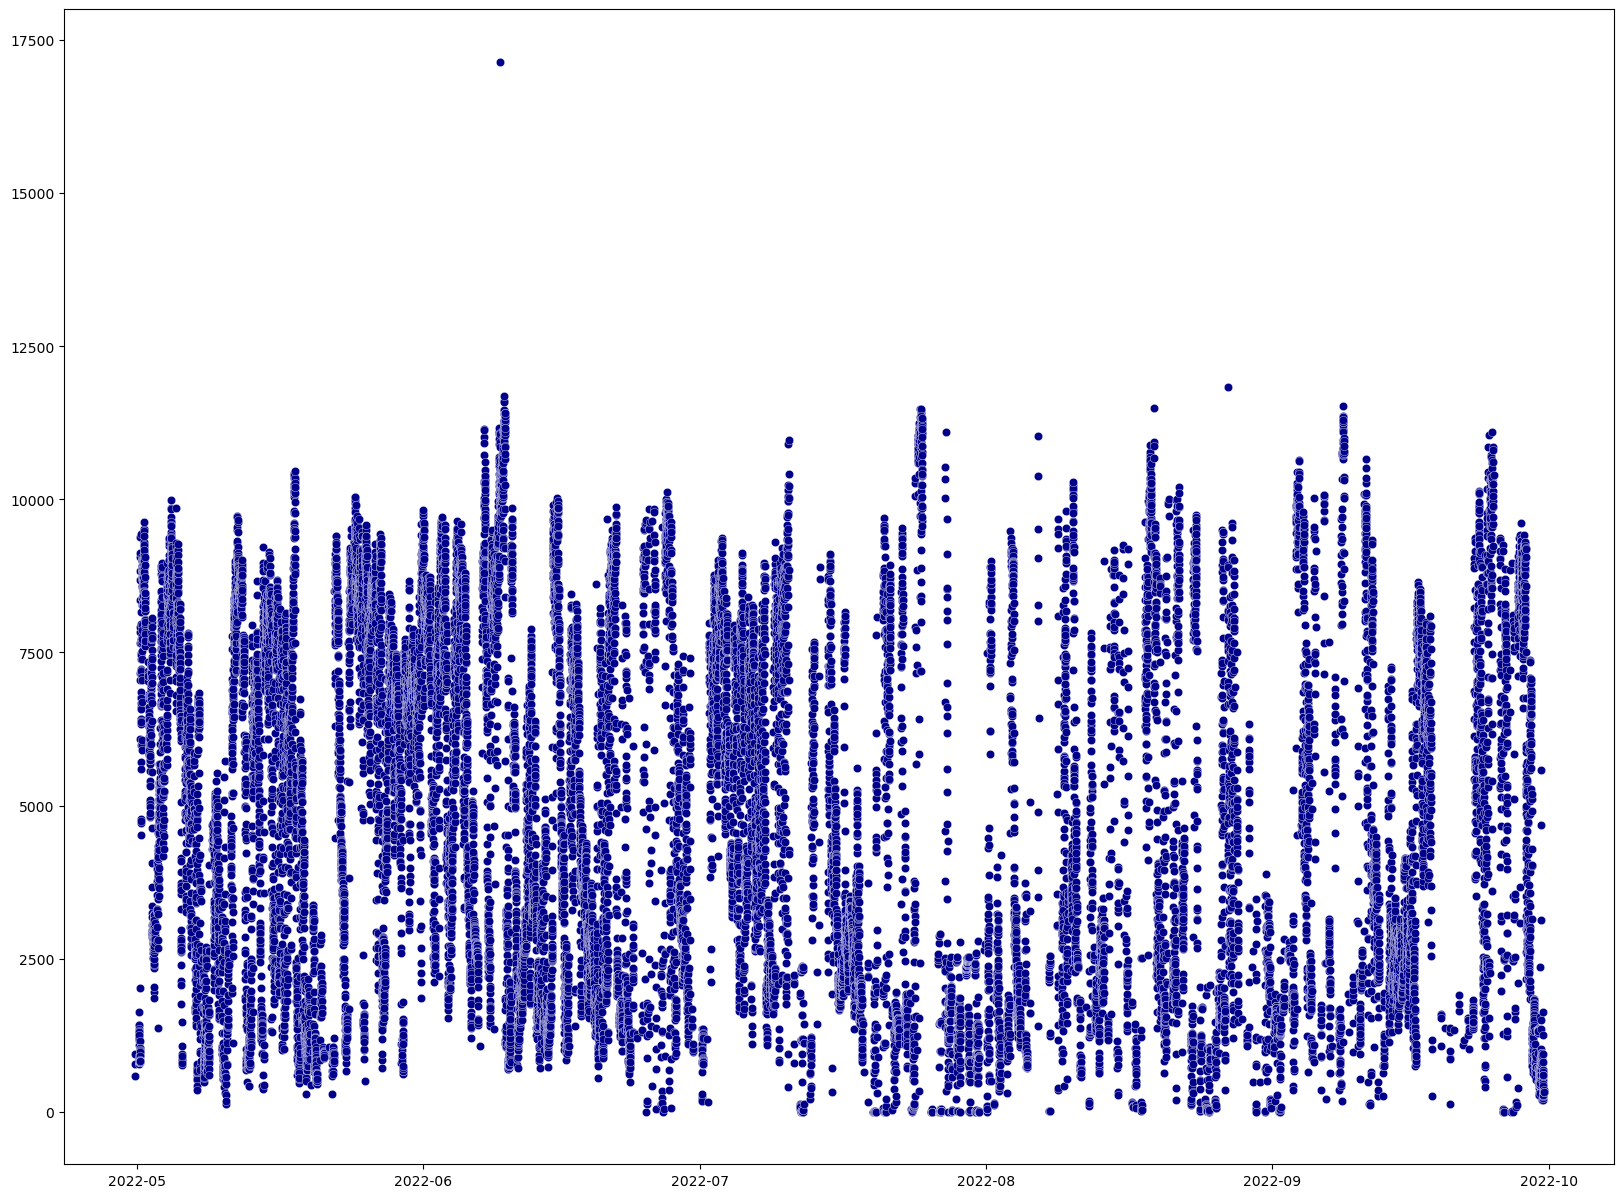

In [13]:
plt.figure(figsize=(20,15))
plt.scatter(fhl_df.index, fhl_df["Height"], color='darkblue', linewidths=0.25, edgecolor='white', label="Cloud Top Height")
# More high clouds earlier in the summer
# More low clouds later in the summer
# More clear sky later in the summer

Text(0.5, 1.0, "Friday Harbor Lab's Cloud Top Height May-Sep 2022")

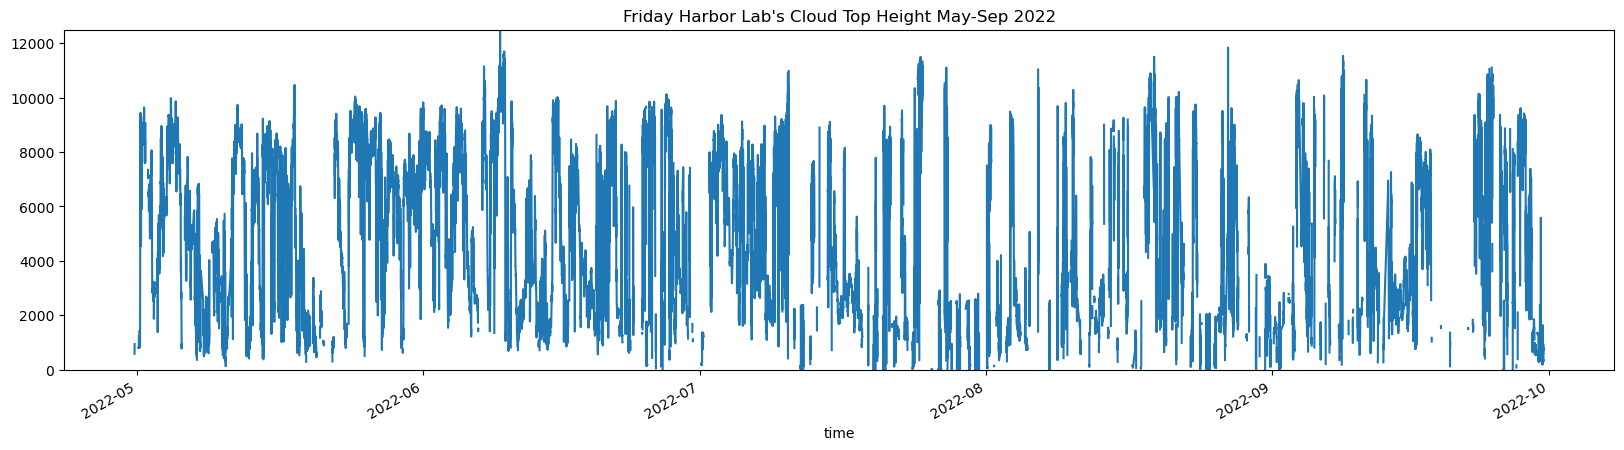

In [26]:
plt.figure(figsize=(20,5))
fhl_df["Height"].plot(ylim = (0,12500))
plt.title("Friday Harbor Lab's Cloud Top Height May-Sep 2022")
# More high clouds earlier in the summer
# More low clouds later in the summer
# More clear sky later in the summer